# Imports

In [1]:
# Import package EquiPy (pip install from GitHub to have the latest version)
from equipy import metrics
from equipy import fairness
from equipy import graphs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
np.random.seed(2000)

In [2]:
from equipy.fairness import FairWasserstein, MultiWasserstein

In [3]:
# Import dataset
df = pd.read_csv('../data/data_mortality.csv')
print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  547878
Number of columns in the dataset:  16


In [4]:
result = df.groupby('Sex')['Origin'].value_counts(normalize=True).reset_index(name='Percentage')
result

,Sex,Origin,Percentage
0,Female,White,0.958803
1,Female,Hispanic,0.026926
2,Female,Asian or Pacific Islander,0.007510
3,Female,Black,0.004289
4,Female,American Indian/AK Native,0.002473
5,Male,White,0.974409
6,Male,Hispanic,0.015222
7,Male,Asian or Pacific Islander,0.006022
8,Male,Black,0.002460
9,Male,American Indian/AK Native,0.001887


In [5]:
print("Column types:\n", df.dtypes)

Column types:
 d                   int64
exposure          float64
duration            int64
Age                 int64
Sex                object
reg_nod_pos         int64
Mitoticrate         int64
Laterality         object
Ulceration         object
Site_rec_WHO08     object
Origin             object
Mar_stat           object
Extent             object
Surg_primsite      object
Tumor              object
Positive_Node      object
dtype: object


# Predictive modelling

In [6]:
# Perform one-hot encoding for categorical variables to apply Random Forest
df_encoded = pd.get_dummies(df, columns=['Sex', 'Laterality', 'Ulceration',
                                         'Site_rec_WHO08', 'Origin', 'Mar_stat',
                                         'Extent', 'Surg_primsite', 'Tumor',
                                         'Positive_Node'], drop_first=True)

In [7]:
# Split the data into train, calibration and test sets
# During mitigation, we will need the calibration set and we won't touch the train set
X = df_encoded.drop("d", axis=1)
y = df_encoded["d"]

# Splitting into two datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
weights_train = np.array(X_train['exposure'])
#weights_calib = np.array(X_calib['exposure'])
#weights_test = np.array(X_test['exposure'])
X_train = X_train.drop("exposure", axis=1)
X_calib = X_calib.drop("exposure", axis=1)
X_test = X_test.drop("exposure", axis=1)

In [72]:
# Create a Random Forest classifier
#rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf = 100, random_state=42)

# Fit the classifier to the training data
#rf_classifier.fit(X_train, y_train, sample_weight=weights_train)

# Get predicted scores of calibration and test sets
#scores_train = rf_classifier.predict_proba(X_train)[:, 1]
#scores_calib = rf_classifier.predict_proba(X_calib)[:, 1]
#scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [9]:
from sklearn.linear_model import LogisticRegression

# Create and train the logistic regression model
LR = LogisticRegression()
LR.fit(X_train, y_train, sample_weight=weights_train)

# Get predicted scores of calibration and test sets
scores_train = LR.predict_proba(X_train)[:, 1]
scores_calib = LR.predict_proba(X_calib)[:, 1]
scores_test = LR.predict_proba(X_test)[:, 1]


In [10]:
df_train = df.iloc[X_train.index,:]
plot_df = pd.DataFrame({'scores': scores_train, 'origin': df_train['Origin']})

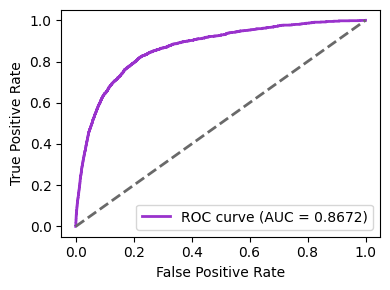

In [11]:
# ROC curve on calibration and test sets

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area under the curve (AUC)
y_true = np.concatenate((y_calib, y_test))
scores = np.concatenate((scores_calib, scores_test))
fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc), 
         color='darkorchid')
plt.plot([0, 1], [0, 1], color='dimgrey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC Curve on test set')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('ROC.pdf')

# Display the plot
plt.show()

# Find the optimal threshold based on the ROC curve for calibration and test sets
#optimal_threshold_index = np.argmax(tpr - fpr)
#optimal_threshold = thresholds[optimal_threshold_index]

#print("Optimal Threshold:", optimal_threshold)


In [76]:
#from sklearn.metrics import f1_score
# Define a range of thresholds to evaluate
#thresholds = np.arange(0.1, 1.0, 0.001)
# Initialize variables to store optimal values
#best_threshold = 0
#best_f1 = 0

# Iterate through thresholds and calculate F1 score
#for threshold in thresholds:
    #y_true = np.concatenate((y_calib, y_test))
    #scores = np.concatenate((scores_calib, scores_test))
    #predicted_labels = (scores_train > threshold).astype(int)
    #f1 = f1_score(y_train, predicted_labels)
    
    # Update optimal values if F1 score is higher
    #if f1 > best_f1:
    #    best_f1 = f1
    #    best_threshold = threshold

# Print the optimal threshold and F1 score
#print(f"Optimal Threshold: {best_threshold:.4f}")
#print(f"Optimal F1 Score: {best_f1:.4f}")

In [12]:
# Define classes on predicted scores for each dataset
#threshold = best_threshold
threshold = 0.1020
y_pred_train = (scores_train > threshold).astype(int)
y_pred_calib = (scores_calib > threshold).astype(int)
y_pred_test = (scores_test > threshold).astype(int)

In [13]:
# Evaluate the classifier : no overfitting
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_calib = accuracy_score(y_calib, y_pred_calib)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on train dataset: {accuracy_train:.2f}")
print(f"Accuracy on calibration dataset: {accuracy_calib:.2f}")
print(f"Accuracy on test dataset: {accuracy_test:.2f}")

Accuracy on train dataset: 0.99
Accuracy on calibration dataset: 0.99
Accuracy on test dataset: 0.99


In [14]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Calculate confusion matrix on test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Calculate precision
precision = precision_score(y_test, y_pred_test)
# Calculate recall
recall = recall_score(y_test, y_pred_test)

print("Confusion matrix on test dataset:\n", conf_matrix)
print(f"Precision on test dataset: {precision:.2f}")
print(f"Recall on test dataset: {recall:.2f}")

Confusion matrix on test dataset:
 [[107954    816]
 [   691    115]]
Precision on test dataset: 0.12
Recall on test dataset: 0.14


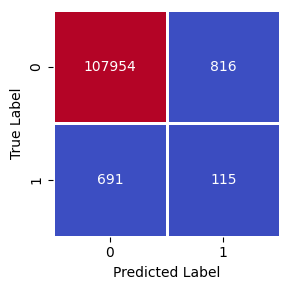

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

LABELS = ['0', '1']

def show_confusion_matrix(observations, predictions, title=None):
    matrix = confusion_matrix(observations, predictions)

    plt.figure(figsize=(3, 3))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                cbar=False)
    #if title: plt.title(title)
    #else: plt.title('Confusion Matrix on test set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("cm.png")
    plt.show()

show_confusion_matrix(y_test, y_pred_test)

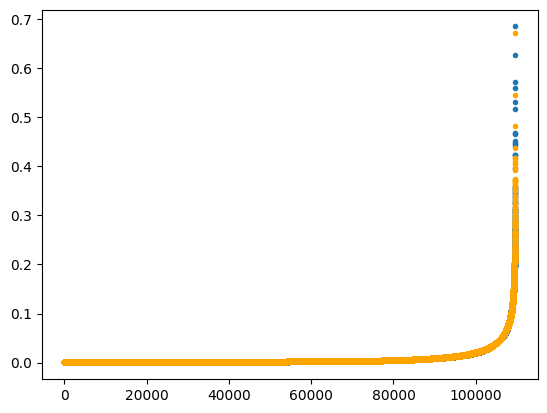

In [212]:
# Plot distributions
plt.plot(sorted(scores_calib), '.')
plt.plot(sorted(scores_test), '.', color = "orange")
plt.show()

# Preparation for Wasserstein classes

In [15]:
# Test and calibration datasets without one-hot encoding
df_calib = df.loc[X_calib.index]
df_test = df.loc[X_test.index]

In [16]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Origin','Sex']].to_numpy()
x_ssa_test = df_test[['Origin','Sex']].to_numpy()
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)
# Predicted scores because EquiPy deals with real-valued outcomes

In [13]:
# Functions available in module fairness, graphs and metrics
print(dir(fairness))
print(dir(metrics))
print(dir(graphs))

['FairWasserstein', 'MultiWasserstein', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_base', '_wasserstein']
['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_fairness_metrics', '_performance_metrics', 'performance', 'unfairness']
['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_arrow_plot', '_density_plot', '_waterfall_plot', 'fair_arrow_plot', 'fair_density_plot', 'fair_multiple_arrow_plot', 'fair_waterfall_plot']


In [121]:
# Documentation of the class MultiWasserstein
#help(fairness.MultiWasserstein)

In [82]:
# Functions available in the class fairness.MultiWasserstein
class_functions = [function for function in dir(fairness.MultiWasserstein) if callable(getattr(fairness.MultiWasserstein, function))]
print("Functions of the class:", class_functions)

Functions of the class: ['__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'fit', 'transform']


In [15]:
# Calculation of unfairness before applying mitigation
from equipy.metrics import unfairness
# We can't calculate the unfairness for the true values of y because it is not real-valued and only takes 0/1
# When doing classification task, we expect scores and not 0/1
unfairness(y_true_test, x_ssa_test)


1.0

In [17]:
"""
Computation of the fairness (i.e. measurement of the similarity in prediction distribution between different population groups according to their sensitive attributes).
"""

# Authors: Agathe F, Suzie G, Francois H, Philipp R, Arthur C
# License: BSD 3 clause
import numpy as np
import warnings
from scipy.interpolate import interp1d
import numpy as np
import ot
from typing import Union

# WARNING:You cannot calculate the EQF function of a single value : this means that if only one individual
# has a specific sensitive value, you cannot use the transform function.


class EQF:
    """
    Empirical Quantile Function (EQF) Class.

    This class computes the linear interpolation of the empirical quantile function for a given set of sample data.

    Parameters
    ----------
    sample_data : array-like
        A 1-D array or list-like object containing the sample data.

    Attributes
    ----------
    interpolater : scipy.interpolate.interp1d
        An interpolation function that maps quantiles to values.
    min_val : float
        The minimum value in the sample data.
    max_val : float
        The maximum value in the sample data.

    Methods
    -------
    __init__(sample_data)
        Initializes the EQF object by calculating the interpolater, min_val, and max_val.
    _calculate_eqf(sample_data)
        Private method to calculate interpolater, min_val, and max_val.
    __call__(value_)
        Callable method to compute the interpolated value for a given quantile.

    Raises
    ------
    ValueError
        If the input value_ is outside the range [0, 1].

    Example 
    -------
    >>> sample_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    >>> eqf = EQF(sample_data)
    >>> print(eqf([0.2, 0.5, 0.8]))  # Interpolated value at quantiles 0.2, 0.5, and 0.8
    [2.8 5.5 8.2]

    Note
    ----
    - The EQF interpolates values within the range [0, 1] representing quantiles.
    - The input sample_data should be a list or array-like containing numerical values.
    """

    def __init__(self, sample_data: Union[np.ndarray, list[float]]):
        self._calculate_eqf(sample_data)
        if len(sample_data) == 1:
            warnings.warn('One of your sample data contains a single value')

    def _calculate_eqf(self, sample_data: Union[np.ndarray, list[float]]) -> None:
        """
        Calculate the Empirical Quantile Function for the given sample data.

        Parameters
        ----------
        sample_data : array-like
            A 1-D array or list-like object containing the sample data.

        Returns
        -------
        EQF
            An instance of the Empirical Quantile Function (EQF) class.

        Notes
        -----
        The EQF interpolates values within the range [0, 1] representing quantiles.
        The input sample_data should be a list or array-like containing numerical values.
        """
        sorted_data = np.sort(sample_data)
        linspace = np.linspace(0, 1, num=len(sample_data))

        if len(sample_data) == 1:
            linspace = np.linspace(0, 1, num=2)
            self.interpolater = interp1d(
                linspace, [sorted_data[0]]*len(linspace))

        else:
            self.interpolater = interp1d(linspace, sorted_data)

        self.min_val = sorted_data[0]
        self.max_val = sorted_data[-1]

    def __call__(self, value_: float) -> float:
        """
        Compute the interpolated value for a given quantile.

        Parameters
        ----------
        value_ : float
            Array of quantile values between 0 and 1.

        Returns
        -------
        float
            Interpolated value corresponding to the input quantile.

        Raises
        ------
        ValueError
            If the input value_ is outside the range [0, 1].
        """
        try:
            return self.interpolater(value_)
        except ValueError:
            if (not isinstance(value_, np.ndarray)) and (not isinstance(value_, float)) and (not isinstance(value_, int)):
                raise ValueError(
                    'value_ can only be an array, a float or an integer number')
            elif (isinstance(value_, np.ndarray)) and (not (np.issubdtype(value_, np.floating) or np.issubdtype(value_, np.integer))):
                raise ValueError(
                    'value_ should contain only float or integer numbers')
            elif np.any(value_ < 0) or np.any(value_ > 1):
                raise ValueError(
                    'value_ should contain only numbers between 0 and 1')
            else:
                raise ValueError('Error with input value')


def diff_quantile(data1: np.ndarray, data2: np.ndarray, n_min: float = 1000) -> float:
    """
    Compute the unfairness between two populations based on their quantile functions. 
    If the number of points in data1 is less than n_min, compute the Wasserstein distance using the POT package. 
    Otherwise, determine unfairness as the maximum difference in quantiles between the two populations.

    Parameters
    ----------
    data1 : np.ndarray
        The first set of data points.
    data2 : np.ndarray
        The second set of data points.
    n_min : float
        Below this threshold, compute the Wasserstein distance.

    Returns
    -------
    float
        The unfairness value between the two populations.

    Example
    -------
    >>> data1 = np.array([5, 2, 4, 6, 1])
    >>> data2 = np.array([9, 6, 4, 7, 6])
    >>> diff = compute_unfairness(data1, data2, n_min=5)
    >>> print(diff)
    3.9797979797979797
    """

    n1 = len(data1)  # data1 corresponds to y
    n2 = len(data2)

    if n1 < n_min:
        # weights of each point of the two distributions
        a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2
        M = ot.dist(data1.reshape((n1, 1)), data2.reshape((n2, 1)),
                    metric='euclidean')  # euclidian distance matrix
        M = M/M.max()
        unfair_value = ot.emd2(a, b, M)

    else:
        probs = np.linspace(0.01, 0.99, num=100)
        eqf1 = np.quantile(data1, probs)
        eqf2 = np.quantile(data2, probs)
        unfair_value = np.max(np.abs(eqf1-eqf2))

    return unfair_value


def unfairness(y: np.ndarray, sensitive_features: np.ndarray, n_min: float = 1000) -> float:
    """
    Compute the unfairness value for a given fair output (y) and multiple sensitive attributes data (sensitive_features) containing several modalities.
    If there is a single sensitive feature, it calculates the maximum quantile difference between different modalities of that single sensitive feature.
    If there are multiple sensitive features, it calculates the maximum quantile difference for each sensitive feature
    and then takes the maximum of these maximums.

    Parameters
    ----------
    y : np.ndarray
        Predicted (fair or not) output data.
    sensitive_features : np.ndarray
        Sensitive attribute data.
    n_min : float
        Below this threshold, compute the unfairness based on the Wasserstein distance.

    Returns
    -------
    float
        Unfairness value in the dataset.

    Example
    -------
    >>> y = np.array([5, 0, 6, 7, 9])
    >>> sensitive_features = np.array([[1, 2, 1, 1, 2], [0, 1, 2, 1, 0]]).T
    >>> unf = compute_unfairness(y, sensitive_features, n_min=5)
    >>> print(unf)
    6.0
    """
    new_list = []
    if sensitive_features.ndim == 1:
        modalities = list(set(sensitive_features))
        lst_unfairness = []
        for modality in modalities:
            y_modality = y[sensitive_features == modality]
            lst_unfairness.append(diff_quantile(y, y_modality, n_min))
        unfs = max(lst_unfairness)
    else:
        for sensitive_feature in sensitive_features.T:
            modalities = list(set(sensitive_feature))
            lst_unfairness = []
            for modality in modalities:
                y_modality = y[sensitive_feature == modality]
                lst_unfairness.append(diff_quantile(y, y_modality, n_min))
            new_list.append(max(lst_unfairness))
            #print(new_list)
        unfs = np.sum(new_list)
    return unfs


def unfairness_dict(y_fair_dict: dict[str, np.ndarray], sensitive_features: np.ndarray, n_min: float = 1000) -> dict[str, float]:
    """
    Compute unfairness values for sequentially fair output datasets and multiple sensitive attributes datasets.

    Parameters
    ----------
    y_fair_dict : dict
        A dictionary where keys represent sensitive features and values are arrays
        containing the fair predictions corresponding to each sensitive feature.
        Each sensitive feature's fairness adjustment is performed sequentially,
        ensuring that each feature is treated fairly relative to the previous ones.
    sensitive_features : array-like
        Sensitive attribute data.
    n_min : float
        Below this threshold, compute the unfairness based on the Wasserstein distance.

    Returns
    -------
    dict
        A dictionary containing unfairness values for each level of fairness.
        The level of fairness corresponds to the number of sensitive attributes to which fairness has been applied.

    Example
    -------
    >>> y_fair_dict = {'Base model':np.array([19,39,65]), 'sensitive_feature_1':np.array([22,40,50]), 'sensitive_feature_2':np.array([28,39,42])}
    >>> sensitive_features = np.array([['blue', 2], ['red', 9], ['green', 5]])
    >>> unfs_dict = compute_unfairness_multi(y_fair_dict, sensitive_features, n_min=5)
    >>> print(unfs_dict)
    {'sensitive_feature_0': 46.0, 'sensitive_feature_1': 28.0, 'sensitive_feature_2': 14.0}
    """
    unfairness_dict = {}
    for key, y_fair in y_fair_dict.items():
        result = unfairness(y_fair, sensitive_features, n_min)
        unfairness_dict[key] = result
    return unfairness_dict

# Exact fairness: Beta distributions

In [34]:
# List of values to keep
#values_to_keep = ['White', 'Black', 'Asian']
#alpha_left, beta_left = 2, 5  # Paramètres pour la distribution à gauche
#alpha_right, beta_right = 7, 2  # Paramètres pour la distribution à droite

def calculate_alpha_beta(mean, std):
    alpha = ((1 - mean) / std**2 - 1 / mean) * mean**2
    beta = alpha * (1 / mean - 1)
    return alpha, beta

# Specify mean and standard deviation for the left Beta distribution
mean_left = 0.2
std_left = 0.2
alpha_left, beta_left = calculate_alpha_beta(mean_left, std_left)

# Specify mean and standard deviation for the right Beta distribution
mean_right = 0.8
std_right = 0.05
alpha_right, beta_right = calculate_alpha_beta(mean_right, std_right)



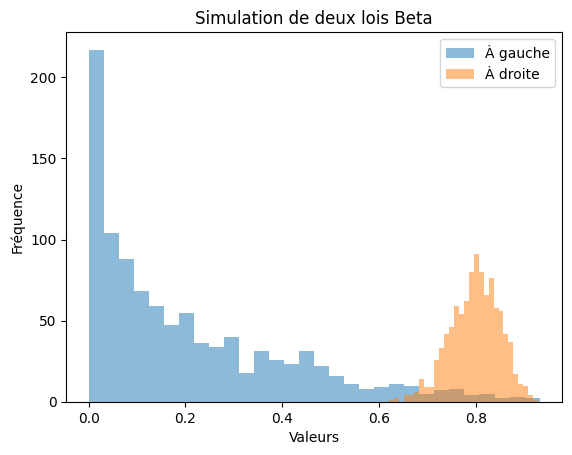

In [35]:
# Générer des échantillons à partir des distributions Beta
samples_left = np.random.beta(alpha_left, beta_left, 1000)
samples_right = np.random.beta(alpha_right, beta_right, 1000)

samples = np.concatenate((samples_left, samples_right))
x_ssa = np.concatenate((["White"] * 1000, ["Black"] * 1000))

# Afficher les histogrammes des échantillons
plt.hist(samples_left, bins=30, alpha=0.5, label='À gauche')
plt.hist(samples_right, bins=30, alpha=0.5, label='À droite')
plt.legend()
plt.title('Simulation de deux lois Beta')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

# Find indices using NumPy's where function
#x_ssa_calib = x_ssa_calib[:,0]
#x_ssa_test = x_ssa_test[:,0]
#indices_calib = np.where(np.isin(x_ssa_calib, values_to_keep))[0]
#indices_test = np.where(np.isin(x_ssa_test, values_to_keep))[0]

In [36]:
# Instance of Wasserstein class : exact fairness
from equipy.fairness import FairWasserstein
# Create instance of Wasserstein class (MSA)
exact_wst = FairWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(samples, x_ssa)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(samples, x_ssa)
print("y_fair :", y_final_fair) # returns the y_fair

y_fair : [0.37023508 0.52548531 0.48479852 ... 0.66380659 0.45971936 0.39850064]


In [37]:
scores = np.concatenate((samples, y_final_fair))
origin = np.concatenate((x_ssa, np.full(len(x_ssa), 'Wasserstein Barycenter')))

In [38]:
plot_df = pd.DataFrame({'scores': scores, 'origin': origin})

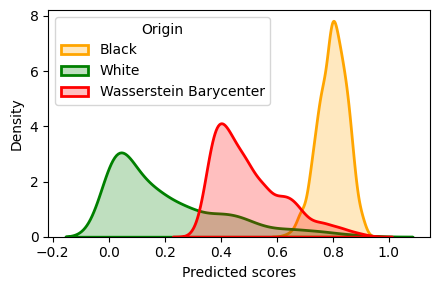

In [41]:
import seaborn as sns
#sns.kdeplot(data=plot_df, x="scores", hue="origin", fill=True, common_norm=False)

# Set the order of superposition
order_of_superposition = ['Black', 'White', 'Wasserstein Barycenter']

# Create a single figure and axes for all KDE plots
fig, ax = plt.subplots(figsize=(4.5, 3))
# Define colors for each group
#colors = ['green','blue', 'purple']


# Plotting densities in the specified order on the same axes
for group in order_of_superposition:
    if group =='White':
        color = 'green'
    elif group == 'Black':
        color = 'orange'
    elif group == 'Black':
        color = 'pink'
    else:
        color = 'red'
    # Filter data for the current group and plot the KDE
    sns.kdeplot(data=plot_df[plot_df['origin'] == group], x='scores', label=group, fill=True, ax=ax, color=color, linewidth = 2)
# Set labels and title for the overall plot
plt.xlabel('Predicted scores')
plt.ylabel('Density')
#plt.xlim(-0.04, 0.11)
#plt.title('KDE Plots for Different Origins')

# Add legend for the overall plot
plt.legend(title='Origin', loc='upper left')
plt.tight_layout()
plt.savefig('wassbary.pdf')
# Show the plot
plt.show()


# Exact fairness: survival data

In [26]:
# Instance of Wasserstein class : exact fairness
from equipy.fairness import MultiWasserstein
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
print("y_fair :", y_final_fair) # returns the y_fair

y_fair : [0.00159311 0.00171235 0.00082605 ... 0.00308772 0.00180595 0.00240166]


In [27]:
# Instance of Wasserstein class : exact fairness
from equipy.fairness import MultiWasserstein
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
print("y_fair :", y_final_fair) # returns the y_fair

y_fair : [0.00157485 0.0016037  0.00092807 ... 0.00333063 0.00176585 0.00239315]


## Unfairness and performance metrics

In [28]:
# Define dictionnaries with unfairness and performance metrics for different permutations of sensitive attributes
unfs_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
             {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]
perf_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
              {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]

In [29]:
# We can calculate fairness of the y_final_fair and on the initial scores_test
#from equipy.metrics import unfairness
print("Unfairness before mitigation: ", unfairness(scores_test, x_ssa_test))
print("Unfairness after mitigating biases from origin and sex: ", unfairness(y_final_fair, x_ssa_test))

Unfairness before mitigation:  0.26679260383844283
Unfairness after mitigating biases from origin and sex:  0.04819192600155221


In [30]:
# To have all the steps of sequential fairness, we can take the dictionnary
# Dictionnary of sequential fair outputs if multiple sensitive attributes
y_seq_fair = exact_wst.y_fair
print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[0]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
# Sensitive features must be classes (multi-class is possible) ! The order depends on what the user has specified
print("Unfairness after mitigating biases from origin: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[0]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from origin and gender: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[0]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

y_sequentially_fair : {'Base model': array([0.00207072, 0.0011715 , 0.00113942, ..., 0.00208238, 0.00214175,
       0.00303961]), 'sensitive_feature_1': array([0.00201406, 0.00110576, 0.0012005 , ..., 0.0021155 , 0.00214871,
       0.00312245]), 'sensitive_feature_2': array([0.00157485, 0.0016037 , 0.00092807, ..., 0.00333063, 0.00176585,
       0.00239315])}
Unfairness before mitigation:  0.26679260383844283
Unfairness after mitigating biases from origin:  0.06539414906943769
Unfairness after mitigating biases from origin and gender:  0.04819192600155221


In [31]:
y2 = y_seq_fair["sensitive_feature_2"]
y1 = y_seq_fair["sensitive_feature_1"]
y0 = scores_test
x_ssa_origin = x_ssa_test[:,0]
x_ssa_gender = x_ssa_test[:,1]
print("Unfairness regarding origin Base model: ", unfairness(y0, x_ssa_origin))
print("Unfairness regarding gender Base model: ", unfairness(y0, x_ssa_gender))
print("Unfairness regarding origin Mitigation origin: ", unfairness(y1, x_ssa_origin))
print("Unfairness regarding gender Mitigation origin: ", unfairness(y1, x_ssa_gender))
print("Unfairness regarding origin Mitigation gender: ", unfairness(y2, x_ssa_origin))
print("Unfairness regarding gender Mitigation gender: ", unfairness(y2, x_ssa_gender))

Unfairness regarding origin Base model:  0.23712654943669192
Unfairness regarding gender Base model:  0.029666054401750894
Unfairness regarding origin Mitigation origin:  0.03452988557602518
Unfairness regarding gender Mitigation origin:  0.030864263493412508
Unfairness regarding origin Mitigation gender:  0.046915487137299025
Unfairness regarding gender Mitigation gender:  0.0012764388642531876


In [32]:
0.046915487137299025+0.0012764388642531876

0.04819192600155221

In [33]:
# We can do the same with metrics : on the final fair y
from equipy.metrics import performance
from sklearn.metrics import accuracy_score, f1_score
# We first need to transform scores predicted into 0/1 values
print("Accuracy before mitigation: ", performance(y_true_test, y_pred_test, accuracy_score))
print("F1-score before mitigation: ", performance(y_true_test, y_pred_test, f1_score))
# Transform y_final_fair into class vector (0/1)
# Set the threshold
print("Optimal threshold:", threshold)
# Convert scores to binary class predictions
class_final_fair = (y_final_fair > threshold).astype(int)
print("Accuracy after mitigating biases from origin and gender: ", performance(y_true_test, class_final_fair, accuracy_score))
print("F1-score after mitigating biases from origin and gender: ", performance(y_true_test, class_final_fair, f1_score))

# No loss in the accuracy

Accuracy before mitigation:  0.9862469883916186
F1-score before mitigation:  0.13241220495106507
Optimal threshold: 0.102
Accuracy after mitigating biases from origin and gender:  0.98700445352997
F1-score after mitigating biases from origin and gender:  0.115527950310559


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

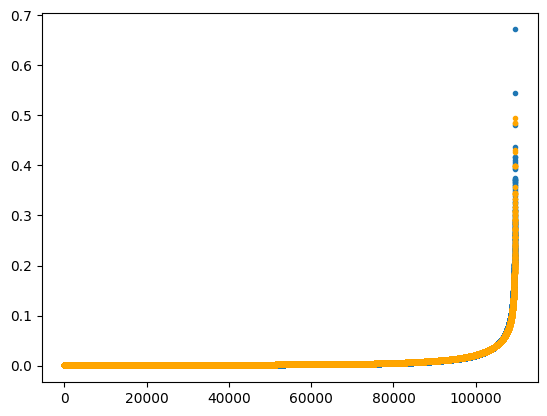

In [33]:
# Plot distributions of predicted scores and final fair scores for test set
plt.plot(sorted(scores_test), '.')
plt.plot(sorted(y_final_fair), '.', color = "orange")
plt.show()

In [34]:
# We can do the same with sequential fairness
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[0]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from origin: ", performance(y_true_test, class_sa_1, metric))
perf_list[0]['sens_var_1'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from origin and gender: ", performance(y_true_test, class_sa_2, metric))
perf_list[0]['sens_var_2'] = performance(y_true_test, class_sa_2, metric)

Accuracy before mitigation:  0.13241220495106507
Accuracy after mitigating biases from origin:  0.12918379330593072
Accuracy after mitigating biases from origin and gender:  0.115527950310559


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

# Approximate fairness

In [18]:
# Instance of Wasserstein class : exact fairness
from equipy.fairness import MultiWasserstein
# Create instance of Wasserstein class (MSA)
approx_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
approx_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = approx_wst.transform(scores_test, x_ssa_test, epsilon=[0,0.5])
print("y_fair :", y_final_fair) # returns the y_fair

y_fair : [0.00195232 0.00133363 0.001083   ... 0.00253526 0.00206132 0.00282471]


In [19]:
# Define dictionnaries with unfairness and performance metrics for different permutations of sensitive attributes
unfs_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
             {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]
perf_list = [{'Base model': 0, 'sens_var_1': 0, 'sens_var_2': 0},
              {'Base model': 0, 'sens_var_2': 0, 'sens_var_1': 0}]

In [20]:
# To have all the steps of sequential fairness, we can take the dictionnary
# Dictionnary of sequential fair outputs if multiple sensitive attributes
y_seq_fair = approx_wst.y_fair
print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[0]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
# Sensitive features must be classes (multi-class is possible) ! The order depends on what the user has specified
print("Unfairness after mitigating biases from origin: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[0]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from origin and gender: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[0]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

y_sequentially_fair : {'Base model': array([0.00207072, 0.0011715 , 0.00113942, ..., 0.00208238, 0.00214175,
       0.00303961]), 'sensitive_feature_1': array([0.00216964, 0.00109647, 0.00118867, ..., 0.00207884, 0.00227267,
       0.00312916]), 'sensitive_feature_2': array([0.00195232, 0.00133363, 0.001083  , ..., 0.00253526, 0.00206132,
       0.00282471])}
Unfairness before mitigation:  0.26679260383844283
Unfairness after mitigating biases from origin:  0.06531383038347387
Unfairness after mitigating biases from origin and gender:  0.04382343443993082


In [21]:
# We can do the same with sequential fairness
from sklearn.metrics import f1_score
from equipy.metrics import performance
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[0]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from origin: ", performance(y_true_test, class_sa_1, metric))
perf_list[0]['sens_var_1'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from origin and gender: ", performance(y_true_test, class_sa_2, metric))
perf_list[0]['sens_var_2'] = performance(y_true_test, class_sa_2, metric)

Accuracy before mitigation:  0.13241220495106507
Accuracy after mitigating biases from origin:  0.12910798122065728
Accuracy after mitigating biases from origin and gender:  0.12669126691266913


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

In [30]:
y2 = y_seq_fair["sensitive_feature_2"]
y1 = y_seq_fair["sensitive_feature_1"]
y0 = scores_test
x_ssa_origin = x_ssa_test[:,0]
x_ssa_gender = x_ssa_test[:,1]
print("Unfairness regarding origin Base model: ", unfairness(y0, x_ssa_origin))
print("Unfairness regarding gender Base model: ", unfairness(y0, x_ssa_gender))
print("Unfairness regarding origin Mitigation origin: ", unfairness(y1, x_ssa_origin))
print("Unfairness regarding gender Mitigation origin: ", unfairness(y1, x_ssa_gender))
print("Unfairness regarding origin Mitigation gender: ", unfairness(y2, x_ssa_origin))
print("Unfairness regarding gender Mitigation gender: ", unfairness(y2, x_ssa_gender))

Unfairness regarding origin Base model:  0.029666054401750894
Unfairness regarding gender Base model:  0.23712654943669192
Unfairness regarding origin Mitigation origin:  0.012741916211618742
Unfairness regarding gender Mitigation origin:  0.22996710858194386
Unfairness regarding origin Mitigation gender:  0.014422846737155298
Unfairness regarding gender Mitigation gender:  0.013560816155163344


In [23]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Sex','Origin']].to_numpy()
x_ssa_test = df_test[['Sex','Origin']].to_numpy()
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)
# Predicted scores because EquiPy deals with real-valued outcomes
#scores_calib
#scores_test
# Instance of Wasserstein class : exact fairness
# Create instance of Wasserstein class (MSA)
approx_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
approx_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = approx_wst.transform(scores_test, x_ssa_test, epsilon=[0.5,0])
#print("y_fair :", y_final_fair) # returns the y_fair
# To have all the steps of sequential fairness, we can take the dictionnary
y_seq_fair = approx_wst.y_fair
#print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[1]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
print("Unfairness after mitigating biases from gender: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[1]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from gender and origin: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[1]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

# We can do the same with sequential fairness
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[1]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender: ", performance(y_true_test, class_sa_1, metric))
perf_list[1]['sens_var_2'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender and origin: ", performance(y_true_test, class_sa_2, metric))
perf_list[1]['sens_var_1'] = performance(y_true_test, class_sa_2, metric)

Unfairness before mitigation:  0.26679260383844283
Unfairness after mitigating biases from gender:  0.2427090247935626
Unfairness after mitigating biases from gender and origin:  0.027983662892318642
Accuracy before mitigation:  0.13241220495106507
Accuracy after mitigating biases from gender:  0.13421210305572198
Accuracy after mitigating biases from gender and origin:  0.1251548946716233


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

## Same code but for a different order of sensitive attributes : Age then Gender

In [35]:
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Sex','Origin']].to_numpy()
x_ssa_test = df_test[['Sex','Origin']].to_numpy()
# True outcome values (0/1)
y_true_calib = np.array(y_calib)
y_true_test = np.array(y_test)
# Predicted scores because EquiPy deals with real-valued outcomes
#scores_calib
#scores_test
# Instance of Wasserstein class : exact fairness
# Create instance of Wasserstein class (MSA)
exact_wst = MultiWasserstein()
# We calculate EQF, ECDF, weights on the calibration set
exact_wst.fit(scores_calib, x_ssa_calib)
# We apply those values to the test set to make it fair
# The transform function returns the final fair y, after mitigating biases from the 2 SA
# First SA : gender, Second : driver's age
y_final_fair = exact_wst.transform(scores_test, x_ssa_test)
#print("y_fair :", y_final_fair) # returns the y_fair
# To have all the steps of sequential fairness, we can take the dictionnary
y_seq_fair = exact_wst.y_fair
#print("y_sequentially_fair :", y_seq_fair)

# Calculate sequential unfairness
print("Unfairness before mitigation: ", unfairness(y_seq_fair["Base model"], x_ssa_test))
unfs_list[1]['Base model'] = unfairness(y_seq_fair["Base model"], x_ssa_test)
print("Unfairness after mitigating biases from gender: ", unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test))
unfs_list[1]['sens_var_2'] = unfairness(y_seq_fair["sensitive_feature_1"], x_ssa_test)
print("Unfairness after mitigating biases from gender and origin: ", unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test))
unfs_list[1]['sens_var_1'] = unfairness(y_seq_fair["sensitive_feature_2"], x_ssa_test)

# We can do the same with sequential fairness
metric = f1_score

# Calculate sequential accuracy
class_base_model = (y_seq_fair["Base model"] > threshold).astype(int)
print("Accuracy before mitigation: ", performance(y_true_test, class_base_model, metric))
perf_list[1]['Base model'] = performance(y_true_test, class_base_model, metric)
class_sa_1 = (y_seq_fair["sensitive_feature_1"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender: ", performance(y_true_test, class_sa_1, metric))
perf_list[1]['sens_var_2'] = performance(y_true_test, class_sa_1, metric)
class_sa_2 = (y_seq_fair["sensitive_feature_2"] > threshold).astype(int)
print("Accuracy after mitigating biases from gender and origin: ", performance(y_true_test, class_sa_2, metric))
perf_list[1]['sens_var_1'] = performance(y_true_test, class_sa_2, metric)

Unfairness before mitigation:  0.26679260383844283
Unfairness after mitigating biases from gender:  0.22159107075482137
Unfairness after mitigating biases from gender and origin:  0.02057474269863622
Accuracy before mitigation:  0.13241220495106507
Accuracy after mitigating biases from gender:  0.12333736396614269
Accuracy after mitigating biases from gender and origin:  0.11601513240857503


/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classification scores
  warnings.warn(
/Users/agathefernandesmachado/Documents/PhD/WIM-concordia/equipy_freMPL/venv/lib/python3.12/site-packages/equipy/utils/checkers.py:22: UserWarning: You used mean squared error as metric but it looks like you are using classificat

In [26]:
unfs_list, perf_list

([{'Base model': 0.26679260383844283,
   'sens_var_1': 0.06531383038347387,
   'sens_var_2': 0.04382343443993082},
  {'Base model': 0.26679260383844283,
   'sens_var_2': 0.2427090247935626,
   'sens_var_1': 0.027983662892318642}],
 [{'Base model': 0.13241220495106507,
   'sens_var_1': 0.12910798122065728,
   'sens_var_2': 0.12669126691266913},
  {'Base model': 0.13241220495106507,
   'sens_var_2': 0.13421210305572198,
   'sens_var_1': 0.1251548946716233}])

In [27]:
unfs_list[1]['sens_var_1'] = 0.04382343443993082
perf_list[1]['sens_var_1'] = 0.12669126691266913

0.16605321711095836 0.13076009308586117 -0.020147877345496897 -0.00033042237304077847
0.054568632411702345 0.12789962406666322 -0.0021490395943543046 -0.0002416714307988149
0.2547508143160027 0.13331215400339352 -0.0024083579044880234 0.00017998981046569163
0.1432662296167467 0.13045168498419557 -0.019888559035363178 -0.000752083614305285
[0.04382343443993082, 0.04382343443993082] [0.26679260383844283, 0.26679260383844283] [0.12669126691266913, 0.12669126691266913] [0.13241220495106507, 0.13421210305572198]


<Axes: title={'center': 'Sequential fairness operation'}, xlabel='Unfairness', ylabel='Performance'>

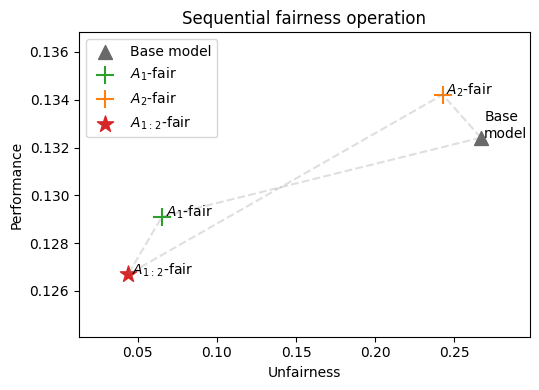

In [28]:
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot

# Packages to import to apply functions at hand
import re

def fair_arrow_plot(unfs_dict: dict[str, np.ndarray],
                    performance_dict: dict[str, np.ndarray],
                    permutations: bool = False,
                    base_model: bool = True,
                    final_model: bool = True) -> plt.Axes:
    """
    Generates an arrow plot representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Parameters
    ----------
    unfs_dict : dict
        A dictionary containing unfairness values associated with the sequentially fair output datasets.
    performance_dict : dict
        A dictionary containing performance values associated with the sequentially fair output datasets.
    permutations : bool, optional
        If True, displays permutations of arrows based on input dictionaries. Defaults to False.
    base_model : bool, optional
        If True, includes the base model arrow. Defaults to True.
    final_model : bool, optional
        If True, includes the final model arrow. Defaults to True.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Note
    ----
    - This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """

    x = []
    y = []
    sens = [0]

    for i, key in enumerate(unfs_dict.keys()):
        x.append(unfs_dict[key])
        if i != 0:
            sens.append(int(''.join(re.findall(r'\d+', key))))
    
    if len(sens) > 2:
        first_sens = sens[1]
        double_sorted_sens = sorted(sens[1:3])
    else:
        first_label_not_used = True
        double_label_not_used = True
    
    if first_sens not in first_current_sens:
        first_current_sens.append(first_sens)
        first_label_not_used = True
    else:
        first_label_not_used = False
    
    if double_sorted_sens not in double_current_sens:
        double_current_sens.append(double_sorted_sens)
        double_label_not_used = True
    else:
        double_label_not_used = False
    
    for key in performance_dict.keys():
        y.append(performance_dict[key])

    global ax

    # Add axes limitations for each permutation
    x_min.append(np.min(x))
    x_max.append(np.max(x))
    y_min.append(np.min(y))
    y_max.append(np.max(y))

    if not permutations:
        fig, ax = plt.subplots()

    line = ax.plot(x, y, linestyle="--", alpha=0.25, color="grey")[0]

    for i in range(len(sens)):
        if i > 0:
            print((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10, (y[i]-y[i-1])/10)
            #ax.arrow((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10,
            #          (y[i]-y[i-1])/10, width = 0.0005, 
            #          color ="grey")
        if (i == 0) & (base_model):
            line.axes.annotate(f"Base\nmodel", xytext=(
                x[0]+np.min(x)/20, y[0]), xy=(x[0], y[0]), size=10)
            ax.scatter(x[0], y[0], label="Base model", marker="^", 
                       color="dimgrey", s=100)
            # Draw an arrow from (1, 1) to (2, 3)
            #ax.arrow(0.1358, 0.1308, -0.0203, -0.0003, width = 0.0005, head_width=0.002, head_length=0.004, fc='#2ca02c', ec='#2ca02c')
            #         lw=2, length_includes_head=True, projection='x[0]y[0]')
            #ax.annotate('', xy=(0.12, 0.13), xytext=(0.12, 0.11), arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->'),)
            #ax.arrow(0.0411, 0.1223, 0.0013, -0.0019, width = 0.0005, head_width=0.005, head_length=0.002, fc='#2ca02c', ec='#2ca02c')
            #ax.arrow(0.231, 0.129, -0.004, -0.002, width = 0.0005, head_width=0.003, head_length=0.002, fc='#ff7f0e', ec='#ff7f0e')
            #ax.arrow(0.1339, 0.1194, -0.0172, -0.0008, width = 0.0005, head_width=0.002, head_length=0.004, fc='#ff7f0e', ec='#ff7f0e')

            # Draw an arrow from (2, 3) to (3, 2)
            ax.arrow(0.2, 0.03, 0.1, -0.01, head_width=0.1, head_length=0.1, fc='green', ec='green')
        elif (i == 1) & (first_label_not_used):
            label = f"$A_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            if sens[i]==1:
                ax.scatter(x[i], y[i], label=label, marker="+", s=150, color = '#2ca02c')
            else:
                ax.scatter(x[i], y[i], label=label, marker="+", s=150, color = '#ff7f0e')
        elif (i == len(x)-1) & (final_model):
            label = f"$A_{1}$" + r"$_:$" + f"$_{i}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="*", s=150,
                       color="#d62728")
            ax.set_xlim((np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, 
                         np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10))
            ax.set_ylim((np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100,
                         np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100))
            print(x_min, x_max, y_min, y_max)
            #print(np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10,
            #np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100, np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100)
        elif (i == 2) & (i < len(x)-1) & (double_label_not_used):
            label = f"$A_{sens[1]}$" + r"$_,$" + f"$_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i!=0) & (i!=len(x)-1):
            ax.scatter(x[i], y[i], marker="+", s=150, color="grey", alpha=0.4)
    ax.set_xlabel("Unfairness")
    ax.set_ylabel("Performance")
    ax.set_title("Sequential fairness operation")
    ax.legend(loc="upper left")
    return ax

def _fair_customized_arrow_plot(unfs_list: list[dict[str, np.ndarray]],
                                performance_list: list[dict[str, np.ndarray]]) -> plt.Axes:
    """
    Plot arrows representing the fairness-performance ccombinations step by step (by sensitive attribute) to reach fairness for all permutations
    (order of sensitive variables for which fairness is calculated).

    Parameters
    ----------
    unfs_list : list
        A list of dictionaries containing unfairness values for each permutation of fair output datasets.
    performance_list : list
        A list of dictionaries containing performance values for each permutation of fair output datasets.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness for each combination.

    Note
    ----
    This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """
    global ax
    global double_current_sens
    double_current_sens = []
    global first_current_sens
    first_current_sens = []
    # Define axes limitations
    global x_min, x_max, y_min, y_max
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    fig, ax = plt.subplots(figsize=(5.5, 4))
    for i in range(len(unfs_list)):
        if i == 0:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, final_model=False)
        elif i == len(unfs_list)-1:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, base_model=False)
        else:
            fair_arrow_plot(unfs_list[i], performance_list[i], permutations=True,
                            base_model=False, final_model=False)
    plt.tight_layout()
    plt.savefig('arrowplot.pdf')
    return ax

_fair_customized_arrow_plot(unfs_list, perf_list)

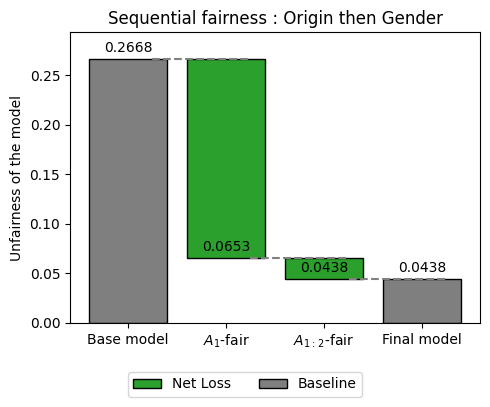

<Axes: title={'center': 'Sequential fairness : Origin then Gender'}, ylabel='Unfairness of the model'>

In [29]:
#from equipy.graphs import fair_waterfall_plot

"""
Representation of sequential gain in fairness.
"""

# Authors: Agathe F, Suzie G, Francois H, Philipp R, Arthur C
# License: BSD 3 clause
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Union, Optional


def _set_colors(substraction_list: list[float]) -> list[str]:
    """
    Assign colors to bars based on the values in the subtraction_list.

    Parameters
    ----------
    subtraction_list : list
        A list of numerical values representing the differences between two sets.

    Returns
    -------
    list
        A list of color codes corresponding to each value in subtraction_list.

    Notes
    -----
    - The color 'tab:orange' is assigned to positive values,
      'tab:green' to non-positive values, and 'tab:grey' to the first and last positions.
    """

    bar_colors = ['tab:grey']
    for i in range(1, len(substraction_list)-1):
        if substraction_list[i] > 0:
            bar_colors.append('tab:orange')
        else:
            bar_colors.append('tab:green')
    bar_colors.append('tab:grey')

    return bar_colors


def _add_bar_labels(values: list[float], pps: list[plt.bar], ax: plt.Axes) -> plt.Axes:
    """
    Add labels to the top of each bar in a bar plot.

    Parameters
    ----------
    values : list
        A list of numerical values representing the heights of the bars.
    pps : list
        A list of bar objects returned by the bar plot.
    ax : matplotlib.axes.Axes
        The Axes on which the bars are plotted.

    Returns
    -------
    matplotlib.axes.Axes
        Text object representing the labels added to the top of each bar in the plot.
    """

    true_values = values + (values[-1],)

    for i, p in enumerate(pps):
        height = true_values[i]
        ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    return ax


def _add_doted_points(ax: plt.Axes, values: np.ndarray) -> plt.Axes:
    """
    Add dotted lines at the top of each bar in a bar plot.

    Parameters
    ----------
    ax : numpy.ndarray
        The Axes on which the bars are plotted.

    values : numpy.ndarray
        An array of numerical values representing the heights of the bars.

    Returns
    -------
    matplotlib.axes.Axes
        The dotted lines at the top of each bar in a bar plot

    This function adds dotted lines at the top of each bar in a bar plot, corresponding to the height values.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots()
    >>> values = np.array([10, 15, 7, 12, 8])
    >>> add_dotted_lines(ax, values)
    >>> plt.show()
    """
    for i, v in enumerate(values):
        ax.plot([i+0.25, i+1.25], [v, v],
                linestyle='--', linewidth=1.5, c='grey')
    return ax


def _add_legend(pps: list[plt.bar], distance: Union[np.ndarray, list], hatch: bool = False) -> list[plt.bar]:
    """
    Add legend labels to the bar plot based on the distances.

    Parameters
    ----------
    pps : List[plt.bar]
        List of bar objects.
    distance : np.ndarray or list
        Array or list of numerical values representing distances.
    hatch : bool, optional
        If True, uses hatching for the legend labels. Defaults to False.

    Returns
    -------
    List[plt.bar]
        List of bar objects with legend labels added.
    """
    used_labels = set()
    for i, bar in enumerate(pps):
        if i == 0 or i == len(pps)-1:
            continue

        if hatch:
            label = 'Net Loss (if exact)' if distance[i] < 0 else 'Net Gain (if exact)'
        else:
            label = 'Net Loss' if distance[i] < 0 else 'Net Gain'

        if label not in used_labels:
            bar.set_label(label)
            used_labels.add(label)
    return pps


def _values_to_distance(values: list[float]) -> list[float]:
    """
    Convert a list of values to a list of distances between consecutive values.

    Parameters
    ----------
    values : list
        A list of numerical values.

    Returns
    -------
    list
        A list of distances between consecutive values.

    Notes
    -----
    This function calculates the differences between consecutive values in the input list, returning a list
    of distances. The last element in the list is the negation of the last value in the input list.
    """
    arr = np.array(values)
    arr = arr[1:] - arr[:-1]
    distance = list(arr) + [-values[-1]]
    return distance


def fair_waterfall_plot(unfs_exact: dict[str, np.ndarray], unfs_approx: Optional[dict[str, np.ndarray]] = None) -> plt.Axes:
    """
    Generate a waterfall plot illustrating the sequential fairness in a model.

    Parameters
    ----------
    unfs_exact : dict
        Dictionary containing fairness values for each step in the exact fairness scenario.
    unfs_approx : dict, optional
        Dictionary containing fairness values for each step in the approximate fairness scenario. Default is None.

    Returns
    -------
    matplotlib.axes.Axes
        The Figure object representing the waterfall plot.

    Notes
    -----
    The function creates a waterfall plot with bars representing the fairness values at each step.
    If both exact and approximate fairness values are provided, bars are color-coded and labeled accordingly.
    The legend is added to distinguish between different bars in the plot.
    """

    fig, ax = plt.subplots(figsize=(5,3.7))

    unfs_exact = {key: round(value, 4) for key, value in unfs_exact.items()}
    if unfs_approx is not None:
        unfs_approx = {key: round(value, 4) for key, value in unfs_approx.items()}

    sens = [int(''.join(re.findall(r'\d+', key))) for key in list(unfs_exact.keys())[1:]]

    labels = []
    for i in range(len(list(unfs_exact.keys())[1:])):
        if i == 0: 
            labels.append(f"$A_{sens[i]}$-fair")
        elif i == len(list(unfs_exact.keys())[1:])-1: 
            labels.append(f"$A_{1}$" + r"$_:$" + f"$_{sens[i]}$-fair")
        else:
            labels.append(f"$A_{{{','.join(map(str, sens[0:i+1]))}}}$-fair")

    leg = ('Base model',) + tuple(labels) + ('Final model',)
    base_exact = list(unfs_exact.values())
    values_exact = [0] + base_exact
    distance_exact = _values_to_distance(values_exact)

    if unfs_approx is not None:

        base_approx = list(unfs_approx.values())
        values_approx = [0] + base_approx
        distance_approx = _values_to_distance(values_approx)

        # waterfall for gray hashed color
        direction = np.array(distance_exact) > 0

        values_grey = np.zeros(len(values_exact))
        values_grey[direction] = np.array(values_approx)[direction]
        values_grey[~direction] = np.array(values_exact)[~direction]

        distance_grey = np.zeros(len(values_exact))
        distance_grey[direction] = np.array(
            values_exact)[direction] - np.array(values_approx)[direction]
        distance_grey[~direction] = np.array(
            values_approx)[~direction] - np.array(values_exact)[~direction]

        # waterfall for exact fairness
        pps0 = ax.bar(leg, distance_exact, color='w', edgecolor=_set_colors(
            distance_exact), bottom=values_exact, hatch='//')

        _add_legend(pps0, distance_exact, hatch=True)

        ax.bar(leg, distance_grey, color='w', edgecolor="grey",
               bottom=values_grey, hatch='//', label='Remains')

        # waterfall for approx. fairness
        pps = ax.bar(leg, distance_approx, color=_set_colors(
            distance_approx), edgecolor='k', bottom=values_approx, label='Baseline')
        _add_legend(pps, distance_approx)

    else:
        # waterfall for exact fairness
        pps = ax.bar(leg, distance_exact, color=_set_colors(
            distance_exact), edgecolor='k', bottom=values_exact, label='Baseline')
        _add_legend(pps, distance_exact)

    fig.legend(loc='upper center', bbox_to_anchor=(
        0.5, 0), ncol=3, fancybox=True)

    _add_bar_labels(tuple(base_exact)
                    if unfs_approx is None else tuple(base_approx), pps, ax)
    _add_doted_points(ax, tuple(base_exact)
                      if unfs_approx is None else tuple(base_approx))
    ax.set_ylabel(f'Unfairness of the model')
    #ax.set_ylim(0, 1.1)
    ax.set_ylim(0,  np.max(list(unfs_exact.values()))+np.max(list(unfs_exact.values()))/10 if unfs_approx is None 
                else np.max(list(unfs_exact.values(), unfs_approx.values()))+np.max(list(unfs_exact.values(), unfs_approx.values()))/10)
    ax.set_title(
        #f'Sequential ({"exact" if unfs_approx is None else "approximate"}) fairness')
        f'Sequential fairness : Origin then Gender')
    plt.tight_layout()
    plt.savefig("waterplot.pdf")
    plt.show()
    return ax

fair_waterfall_plot(unfs_exact = unfs_list[0])

## Visualizations

array([<Axes: title={'center': 'Base model'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'Base model'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_1'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_1'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_2'}, xlabel='Prediction', ylabel='Density'>,
       <Axes: title={'center': 'sensitive_feature_2'}, xlabel='Prediction', ylabel='Density'>],
      dtype=object)

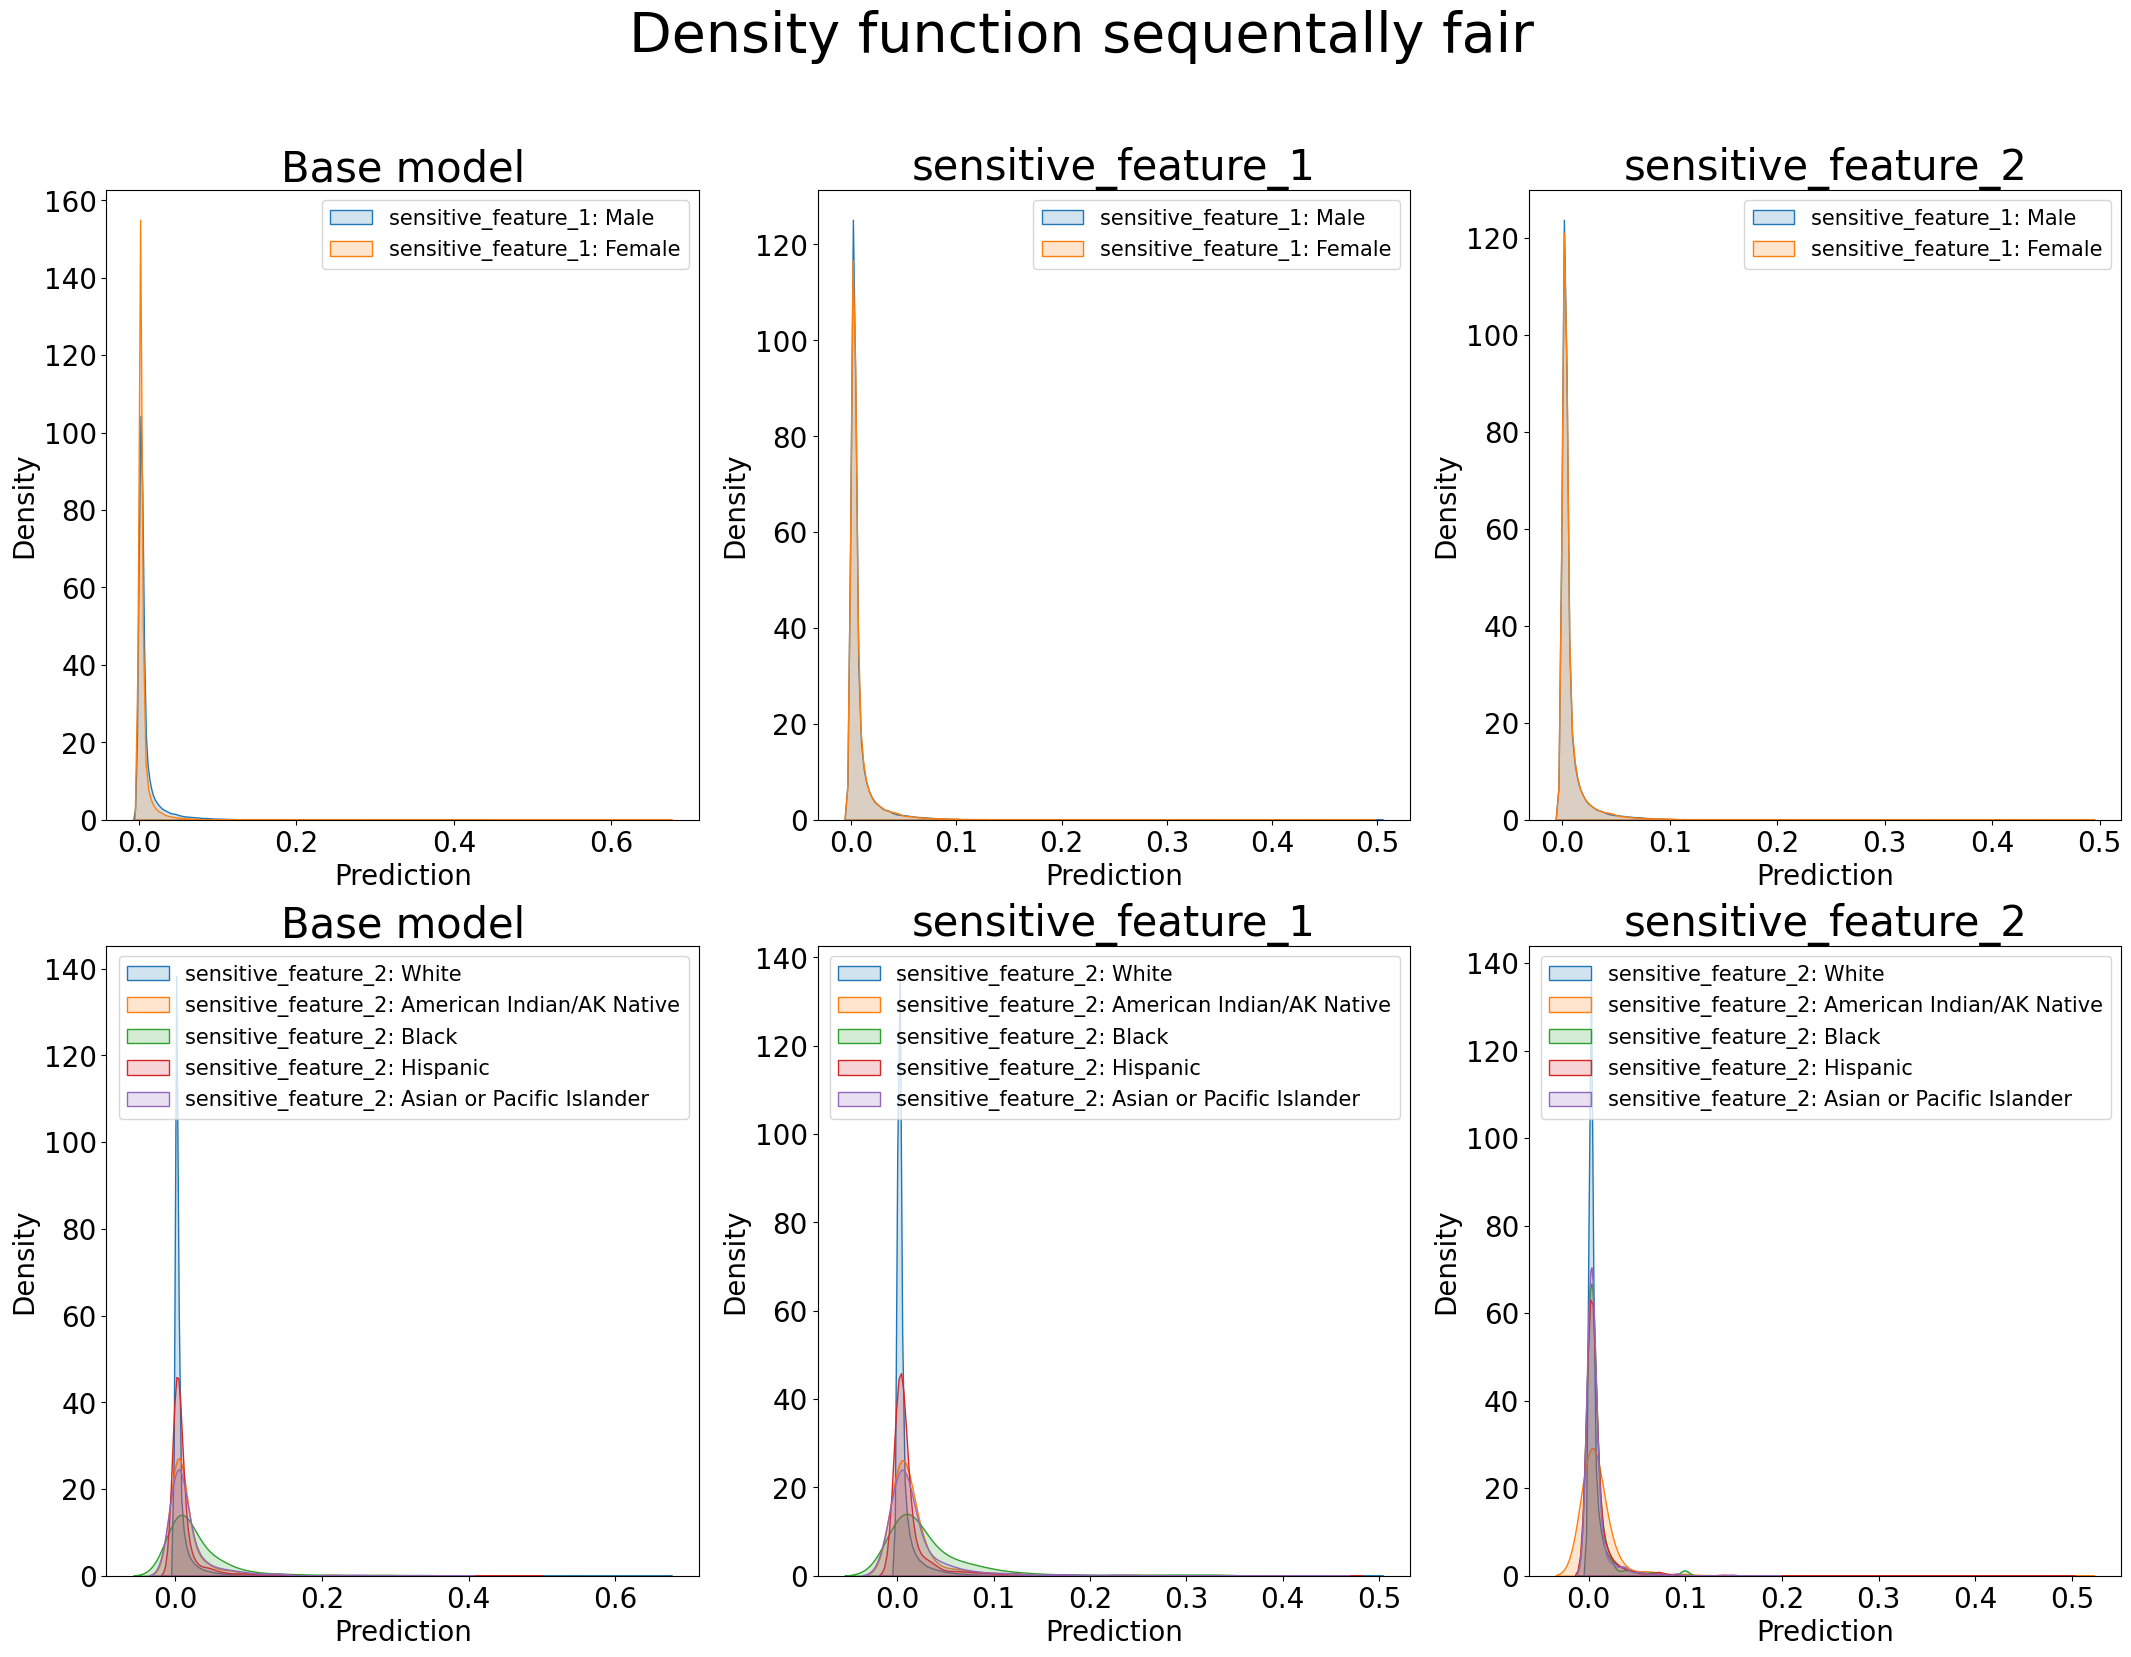

In [25]:
from equipy.graphs import fair_density_plot
fair_density_plot(y_seq_fair, x_ssa_test)

In [30]:
# By hand for now
print(unfs_list)
print(perf_list)

[{'Base model': 0.23712654943669192, 'sens_var_1': 0.034552703018482164, 'sens_var_2': 0.04775524465697428}, {'Base model': 0.23712654943669192, 'sens_var_2': 0.22024351889266203, 'sens_var_1': 0.01900858549387266}]
[{'Base model': 0.13241220495106507, 'sens_var_1': 0.12918379330593072, 'sens_var_2': 0.115527950310559}, {'Base model': 0.13241220495106507, 'sens_var_2': 0.12333736396614269, 'sens_var_1': 0.11565053425518541}]


In [26]:
unfs_list[1]['sens_var_1'] = 0.04768059441852551
perf_list[1]['sens_var_1'] = 0.115527950310559

[0.034552703018482164, 0.04768059441852551] [0.23712654943669192, 0.23712654943669192] [0.115527950310559, 0.115527950310559] [0.13241220495106507, 0.13241220495106507]


<Axes: title={'center': 'Exact fairness'}, xlabel='Unfairness', ylabel='Performance'>

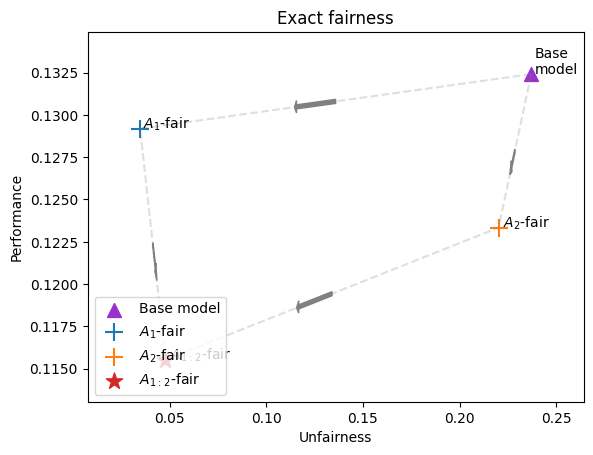

In [25]:
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot

# Packages to import to apply functions at hand
import re

def fair_arrow_plot(unfs_dict: dict[str, np.ndarray],
                    performance_dict: dict[str, np.ndarray],
                    permutations: bool = False,
                    base_model: bool = True,
                    final_model: bool = True) -> plt.Axes:
    """
    Generates an arrow plot representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Parameters
    ----------
    unfs_dict : dict
        A dictionary containing unfairness values associated with the sequentially fair output datasets.
    performance_dict : dict
        A dictionary containing performance values associated with the sequentially fair output datasets.
    permutations : bool, optional
        If True, displays permutations of arrows based on input dictionaries. Defaults to False.
    base_model : bool, optional
        If True, includes the base model arrow. Defaults to True.
    final_model : bool, optional
        If True, includes the final model arrow. Defaults to True.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Note
    ----
    - This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """

    x = []
    y = []
    sens = [0]

    for i, key in enumerate(unfs_dict.keys()):
        x.append(unfs_dict[key])
        if i != 0:
            sens.append(int(''.join(re.findall(r'\d+', key))))
    
    if len(sens) > 2:
        first_sens = sens[1]
        double_sorted_sens = sorted(sens[1:3])
    else:
        first_label_not_used = True
        double_label_not_used = True
    
    if first_sens not in first_current_sens:
        first_current_sens.append(first_sens)
        first_label_not_used = True
    else:
        first_label_not_used = False
    
    if double_sorted_sens not in double_current_sens:
        double_current_sens.append(double_sorted_sens)
        double_label_not_used = True
    else:
        double_label_not_used = False
    
    for key in performance_dict.keys():
        y.append(performance_dict[key])

    global ax

    # Add axes limitations for each permutation
    x_min.append(np.min(x))
    x_max.append(np.max(x))
    y_min.append(np.min(y))
    y_max.append(np.max(y))

    if not permutations:
        fig, ax = plt.subplots()

    line = ax.plot(x, y, linestyle="--", alpha=0.25, color="grey")[0]

    for i in range(len(sens)):
        if i > 0:
            ax.arrow((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10,
                      (y[i]-y[i-1])/10, width = (np.max(y)-np.min(y))/70, 
                      color ="grey")
        if (i == 0) & (base_model):
            line.axes.annotate(f"Base\nmodel", xytext=(
                x[0]+np.min(x)/20, y[0]), xy=(x[0], y[0]), size=10)
            ax.scatter(x[0], y[0], label="Base model", marker="^", 
                       color="darkorchid", s=100)
        elif (i == 1) & (first_label_not_used):
            label = f"$A_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i == len(x)-1) & (final_model):
            label = f"$A_{1}$" + r"$_:$" + f"$_{i}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="*", s=150,
                       color="#d62728")
            ax.set_xlim((np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, 
                         np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10))
            ax.set_ylim((np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100,
                         np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100))
            print(x_min, x_max, y_min, y_max)
            #print(np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10,
            #np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100, np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100)
        elif (i == 2) & (i < len(x)-1) & (double_label_not_used):
            label = f"$A_{sens[1]}$" + r"$_,$" + f"$_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i!=0) & (i!=len(x)-1):
            ax.scatter(x[i], y[i], marker="+", s=150, color="grey", alpha=0.4)
    ax.set_xlabel("Unfairness")
    ax.set_ylabel("Performance")
    ax.set_title("Exact fairness")
    ax.legend(loc="lower left")
    return ax

def _fair_customized_arrow_plot(unfs_list: list[dict[str, np.ndarray]],
                                performance_list: list[dict[str, np.ndarray]]) -> plt.Axes:
    """
    Plot arrows representing the fairness-performance ccombinations step by step (by sensitive attribute) to reach fairness for all permutations
    (order of sensitive variables for which fairness is calculated).

    Parameters
    ----------
    unfs_list : list
        A list of dictionaries containing unfairness values for each permutation of fair output datasets.
    performance_list : list
        A list of dictionaries containing performance values for each permutation of fair output datasets.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness for each combination.

    Note
    ----
    This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """
    global ax
    global double_current_sens
    double_current_sens = []
    global first_current_sens
    first_current_sens = []
    # Define axes limitations
    global x_min, x_max, y_min, y_max
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    fig, ax = plt.subplots()
    for i in range(len(unfs_list)):
        if i == 0:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, final_model=False)
        elif i == len(unfs_list)-1:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, base_model=False)
        else:
            fair_arrow_plot(unfs_list[i], performance_list[i], permutations=True,
                            base_model=False, final_model=False)
    
    return ax

_fair_customized_arrow_plot(unfs_list, perf_list)

0.16609337645394026 0.13079799912849788 -0.020139845476900516 -0.0003228411645134349
0.05679303753549495 0.12235587180824486 -0.0017202223067885477 -0.0013655842995371717
0.2441918372966321 0.12787478445860387 -0.0045201533083621456 -0.0009074840984922381
0.13489149837818679 0.11943265713835084 -0.017339914475326918 -0.0007809413655583686
[0.04819192600155221, 0.04819192600155221] [0.26679260383844283, 0.26679260383844283] [0.115527950310559, 0.115527950310559] [0.13241220495106507, 0.13241220495106507]


<Axes: title={'center': 'Sequential fairness operation'}, xlabel='Unfairness', ylabel='Performance'>

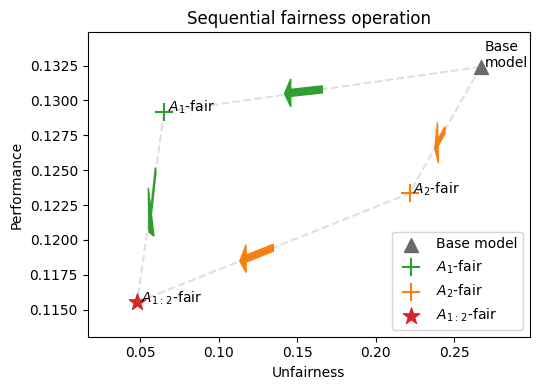

In [50]:
from equipy.graphs import fair_arrow_plot, fair_multiple_arrow_plot

# Packages to import to apply functions at hand
import re

def fair_arrow_plot(unfs_dict: dict[str, np.ndarray],
                    performance_dict: dict[str, np.ndarray],
                    permutations: bool = False,
                    base_model: bool = True,
                    final_model: bool = True) -> plt.Axes:
    """
    Generates an arrow plot representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Parameters
    ----------
    unfs_dict : dict
        A dictionary containing unfairness values associated with the sequentially fair output datasets.
    performance_dict : dict
        A dictionary containing performance values associated with the sequentially fair output datasets.
    permutations : bool, optional
        If True, displays permutations of arrows based on input dictionaries. Defaults to False.
    base_model : bool, optional
        If True, includes the base model arrow. Defaults to True.
    final_model : bool, optional
        If True, includes the final model arrow. Defaults to True.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness.

    Note
    ----
    - This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """

    x = []
    y = []
    sens = [0]

    for i, key in enumerate(unfs_dict.keys()):
        x.append(unfs_dict[key])
        if i != 0:
            sens.append(int(''.join(re.findall(r'\d+', key))))
    
    if len(sens) > 2:
        first_sens = sens[1]
        double_sorted_sens = sorted(sens[1:3])
    else:
        first_label_not_used = True
        double_label_not_used = True
    
    if first_sens not in first_current_sens:
        first_current_sens.append(first_sens)
        first_label_not_used = True
    else:
        first_label_not_used = False
    
    if double_sorted_sens not in double_current_sens:
        double_current_sens.append(double_sorted_sens)
        double_label_not_used = True
    else:
        double_label_not_used = False
    
    for key in performance_dict.keys():
        y.append(performance_dict[key])

    global ax

    # Add axes limitations for each permutation
    x_min.append(np.min(x))
    x_max.append(np.max(x))
    y_min.append(np.min(y))
    y_max.append(np.max(y))

    if not permutations:
        fig, ax = plt.subplots()

    line = ax.plot(x, y, linestyle="--", alpha=0.25, color="grey")[0]

    for i in range(len(sens)):
        if i > 0:
            #print((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10, (y[i]-y[i-1])/10)
            #ax.arrow((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10,
            #          (y[i]-y[i-1])/10, width = 0.0005, 
            #          color ="grey")
            print((x[i-1]+x[i])/2, (y[i-1]+y[i])/2, (x[i]-x[i-1])/10,
                      (y[i]-y[i-1])/10)
        if (i == 0) & (base_model):
            line.axes.annotate(f"Base\nmodel", xytext=(
                x[0]+np.min(x)/20, y[0]), xy=(x[0], y[0]), size=10)
            ax.scatter(x[0], y[0], label="Base model", marker="^", 
                       color="dimgrey", s=100)
            # Draw an arrow from (1, 1) to (2, 3)
            ax.arrow(0.16609337645394026, 0.13079799912849788, -0.0201, -0.00025, width = 0.0005, head_width=0.002, head_length=0.004, fc='#2ca02c', ec='#2ca02c')
            #         lw=2, length_includes_head=True, projection='x[0]y[0]')
            #ax.annotate('', xy=(0.12, 0.13), xytext=(0.12, 0.11), arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->'),)
            ax.arrow(0.06, 0.125, -0.0029, -0.003, width = 0.0005, head_width=0.005, head_length=0.002, fc='#2ca02c', ec='#2ca02c')
            ax.arrow(0.2441918372966321, 0.12787478445860387, -0.0045201533083621456, -0.0009074840984922381, width = 0.0005, head_width=0.003, head_length=0.002, fc='#ff7f0e', ec='#ff7f0e')
            ax.arrow(0.13489149837818679, 0.11943265713835084, -0.017339914475326918, -0.0007809413655583686, width = 0.0005, head_width=0.002, head_length=0.004, fc='#ff7f0e', ec='#ff7f0e')

            # Draw an arrow from (2, 3) to (3, 2)
            ax.arrow(0.2, 0.03, 0.1, -0.01, head_width=0.1, head_length=0.1, fc='green', ec='green')
        elif (i == 1) & (first_label_not_used):
            label = f"$A_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            if sens[i]==1:
                ax.scatter(x[i], y[i], label=label, marker="+", s=150, color = '#2ca02c')
            else:
                ax.scatter(x[i], y[i], label=label, marker="+", s=150, color = '#ff7f0e')
        elif (i == len(x)-1) & (final_model):
            label = f"$A_{1}$" + r"$_:$" + f"$_{i}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="*", s=150,
                       color="#d62728")
            ax.set_xlim((np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, 
                         np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10))
            ax.set_ylim((np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100,
                         np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100))
            print(x_min, x_max, y_min, y_max)
            #print(np.min(x_min)-np.min(x_min)/10-np.max(x_max)/10, np.max(x_max)+np.min(x_min)/10+np.max(x_max)/10,
            #np.min(y_min)-np.min(y_min)/100-np.max(y_max)/100, np.max(y_max)+np.min(y_min)/100+np.max(y_max)/100)
        elif (i == 2) & (i < len(x)-1) & (double_label_not_used):
            label = f"$A_{sens[1]}$" + r"$_,$" + f"$_{sens[i]}$-fair"
            line.axes.annotate(label, xytext=(
                x[i]+np.min(x)/20, y[i]), xy=(x[i], y[i]), size=10)
            ax.scatter(x[i], y[i], label=label, marker="+", s=150)
        elif (i!=0) & (i!=len(x)-1):
            ax.scatter(x[i], y[i], marker="+", s=150, color="grey", alpha=0.4)
    ax.set_xlabel("Unfairness")
    ax.set_ylabel("Performance")
    ax.set_title("Sequential fairness operation")
    ax.legend(loc="lower right")
    return ax

def _fair_customized_arrow_plot(unfs_list: list[dict[str, np.ndarray]],
                                performance_list: list[dict[str, np.ndarray]]) -> plt.Axes:
    """
    Plot arrows representing the fairness-performance ccombinations step by step (by sensitive attribute) to reach fairness for all permutations
    (order of sensitive variables for which fairness is calculated).

    Parameters
    ----------
    unfs_list : list
        A list of dictionaries containing unfairness values for each permutation of fair output datasets.
    performance_list : list
        A list of dictionaries containing performance values for each permutation of fair output datasets.

    Returns
    -------
    matplotlib.axes.Axes
        arrows representing the fairness-performance combinations step by step (by sensitive attribute) to reach fairness for each combination.

    Note
    ----
    This function uses a global variable `ax` for plotting, ensuring compatibility with external code.
    """
    global ax
    global double_current_sens
    double_current_sens = []
    global first_current_sens
    first_current_sens = []
    # Define axes limitations
    global x_min, x_max, y_min, y_max
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    fig, ax = plt.subplots(figsize=(5.5, 4))
    for i in range(len(unfs_list)):
        if i == 0:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, final_model=False)
        elif i == len(unfs_list)-1:
            fair_arrow_plot(unfs_list[i], performance_list[i],
                            permutations=True, base_model=False)
        else:
            fair_arrow_plot(unfs_list[i], performance_list[i], permutations=True,
                            base_model=False, final_model=False)
    plt.tight_layout()
    plt.savefig('arrowplot.pdf')
    return ax

_fair_customized_arrow_plot(unfs_list, perf_list)

In [316]:
unfs_list

[{'Base model': 0.23712654943669192,
  'sens_var_1': 0.0344789070610898,
  'sens_var_2': 0.04768059441852551},
 {'Base model': 0.23712654943669192,
  'sens_var_2': 0.22017946696555146,
  'sens_var_1': 0.04768059441852551}]

In [33]:
# DONT USE FOR CLASSIFICATION BECAUSE THE ERROR IS MSE -> WE CANT CHANGE IT FOR NOW
#fair_multiple_arrow_plot(x_ssa_calib, x_ssa_test, scores_calib, scores_test, y_true_test)

0
-0.4 0.0 0.2668
1
0.6 1.0 0.0654
2
1.6 2.0 0.0482
3
2.6 3.0 0.0482


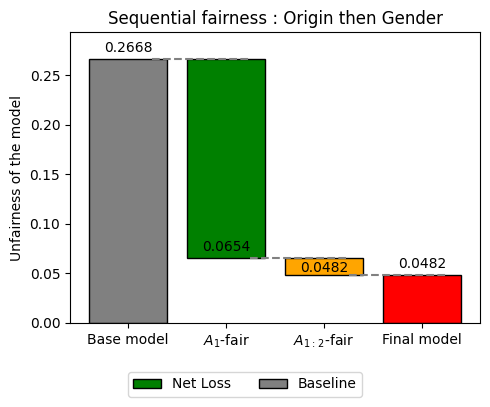

<Axes: title={'center': 'Sequential fairness : Origin then Gender'}, ylabel='Unfairness of the model'>

In [59]:
#from equipy.graphs import fair_waterfall_plot

"""
Representation of sequential gain in fairness.
"""

# Authors: Agathe F, Suzie G, Francois H, Philipp R, Arthur C
# License: BSD 3 clause
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Union, Optional


def _set_colors(substraction_list: list[float]) -> list[str]:
    """
    Assign colors to bars based on the values in the subtraction_list.

    Parameters
    ----------
    subtraction_list : list
        A list of numerical values representing the differences between two sets.

    Returns
    -------
    list
        A list of color codes corresponding to each value in subtraction_list.

    Notes
    -----
    - The color 'tab:orange' is assigned to positive values,
      'tab:green' to non-positive values, and 'tab:grey' to the first and last positions.
    """

    bar_colors = ['tab:grey']
    for i in range(1, len(substraction_list)-1):
        if substraction_list[i] > 0:
            bar_colors.append('tab:orange')
        else:
            bar_colors.append('tab:green')
    bar_colors.append('tab:grey')

    return bar_colors


def _add_bar_labels(values: list[float], pps: list[plt.bar], ax: plt.Axes) -> plt.Axes:
    """
    Add labels to the top of each bar in a bar plot.

    Parameters
    ----------
    values : list
        A list of numerical values representing the heights of the bars.
    pps : list
        A list of bar objects returned by the bar plot.
    ax : matplotlib.axes.Axes
        The Axes on which the bars are plotted.

    Returns
    -------
    matplotlib.axes.Axes
        Text object representing the labels added to the top of each bar in the plot.
    """

    true_values = values + (values[-1],)

    for i, p in enumerate(pps):
        height = true_values[i]
        if i == 2:
            ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')
        else:

            ax.annotate('{}'.format(height),
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        print(i)
        print(p.get_x(), p.get_x() + p.get_width() / 2, height)
    return ax


def _add_doted_points(ax: plt.Axes, values: np.ndarray) -> plt.Axes:
    """
    Add dotted lines at the top of each bar in a bar plot.

    Parameters
    ----------
    ax : numpy.ndarray
        The Axes on which the bars are plotted.

    values : numpy.ndarray
        An array of numerical values representing the heights of the bars.

    Returns
    -------
    matplotlib.axes.Axes
        The dotted lines at the top of each bar in a bar plot

    This function adds dotted lines at the top of each bar in a bar plot, corresponding to the height values.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots()
    >>> values = np.array([10, 15, 7, 12, 8])
    >>> add_dotted_lines(ax, values)
    >>> plt.show()
    """
    for i, v in enumerate(values):
        ax.plot([i+0.25, i+1.25], [v, v],
                linestyle='--', linewidth=1.5, c='grey')
    return ax


def _add_legend(pps: list[plt.bar], distance: Union[np.ndarray, list], hatch: bool = False) -> list[plt.bar]:
    """
    Add legend labels to the bar plot based on the distances.

    Parameters
    ----------
    pps : List[plt.bar]
        List of bar objects.
    distance : np.ndarray or list
        Array or list of numerical values representing distances.
    hatch : bool, optional
        If True, uses hatching for the legend labels. Defaults to False.

    Returns
    -------
    List[plt.bar]
        List of bar objects with legend labels added.
    """
    used_labels = set()
    for i, bar in enumerate(pps):
        if i == 0 or i == len(pps)-1:
            continue

        if hatch:
            label = 'Net Loss (if exact)' if distance[i] < 0 else 'Net Gain (if exact)'
        else:
            label = 'Net Loss' if distance[i] < 0 else 'Net Gain'

        if label not in used_labels:
            bar.set_label(label)
            used_labels.add(label)
    return pps


def _values_to_distance(values: list[float]) -> list[float]:
    """
    Convert a list of values to a list of distances between consecutive values.

    Parameters
    ----------
    values : list
        A list of numerical values.

    Returns
    -------
    list
        A list of distances between consecutive values.

    Notes
    -----
    This function calculates the differences between consecutive values in the input list, returning a list
    of distances. The last element in the list is the negation of the last value in the input list.
    """
    arr = np.array(values)
    arr = arr[1:] - arr[:-1]
    distance = list(arr) + [-values[-1]]
    return distance


def fair_waterfall_plot(unfs_exact: dict[str, np.ndarray], unfs_approx: Optional[dict[str, np.ndarray]] = None) -> plt.Axes:
    """
    Generate a waterfall plot illustrating the sequential fairness in a model.

    Parameters
    ----------
    unfs_exact : dict
        Dictionary containing fairness values for each step in the exact fairness scenario.
    unfs_approx : dict, optional
        Dictionary containing fairness values for each step in the approximate fairness scenario. Default is None.

    Returns
    -------
    matplotlib.axes.Axes
        The Figure object representing the waterfall plot.

    Notes
    -----
    The function creates a waterfall plot with bars representing the fairness values at each step.
    If both exact and approximate fairness values are provided, bars are color-coded and labeled accordingly.
    The legend is added to distinguish between different bars in the plot.
    """

    fig, ax = plt.subplots(figsize=(5,3.7))

    unfs_exact = {key: round(value, 4) for key, value in unfs_exact.items()}
    if unfs_approx is not None:
        unfs_approx = {key: round(value, 4) for key, value in unfs_approx.items()}

    sens = [int(''.join(re.findall(r'\d+', key))) for key in list(unfs_exact.keys())[1:]]

    labels = []
    for i in range(len(list(unfs_exact.keys())[1:])):
        if i == 0: 
            labels.append(f"$A_{sens[i]}$-fair")
        elif i == len(list(unfs_exact.keys())[1:])-1: 
            labels.append(f"$A_{1}$" + r"$_:$" + f"$_{sens[i]}$-fair")
        else:
            labels.append(f"$A_{{{','.join(map(str, sens[0:i+1]))}}}$-fair")

    leg = ('Base model',) + tuple(labels) + ('Final model',)
    base_exact = list(unfs_exact.values())
    values_exact = [0] + base_exact
    distance_exact = _values_to_distance(values_exact)

    if unfs_approx is not None:

        base_approx = list(unfs_approx.values())
        values_approx = [0] + base_approx
        distance_approx = _values_to_distance(values_approx)

        # waterfall for gray hashed color
        direction = np.array(distance_exact) > 0

        values_grey = np.zeros(len(values_exact))
        values_grey[direction] = np.array(values_approx)[direction]
        values_grey[~direction] = np.array(values_exact)[~direction]

        distance_grey = np.zeros(len(values_exact))
        distance_grey[direction] = np.array(
            values_exact)[direction] - np.array(values_approx)[direction]
        distance_grey[~direction] = np.array(
            values_approx)[~direction] - np.array(values_exact)[~direction]

        # waterfall for exact fairness
        pps0 = ax.bar(leg, distance_exact, color='w', edgecolor=_set_colors(
            distance_exact), bottom=values_exact, hatch='//')

        _add_legend(pps0, distance_exact, hatch=True)

        ax.bar(leg, distance_grey, color='w', edgecolor="grey",
               bottom=values_grey, hatch='//', label='Remains')

        # waterfall for approx. fairness
        pps = ax.bar(leg, distance_approx, color=_set_colors(
            distance_approx), edgecolor='k', bottom=values_approx, label='Baseline')
        _add_legend(pps, distance_approx)

    else:
        # waterfall for exact fairness
        #pps = ax.bar(leg, distance_exact, color=_set_colors(
            #distance_exact), edgecolor='k', bottom=values_exact, label='Baseline')
        pps = ax.bar(leg, distance_exact, color=['grey', 'green', 'orange', 'red'], edgecolor='k', bottom=values_exact, label='Baseline')
        _add_legend(pps, distance_exact)

    fig.legend(loc='upper center', bbox_to_anchor=(
        0.5, 0), ncol=3, fancybox=True)

    _add_bar_labels(tuple(base_exact)
                    if unfs_approx is None else tuple(base_approx), pps, ax)
    _add_doted_points(ax, tuple(base_exact)
                      if unfs_approx is None else tuple(base_approx))
    ax.set_ylabel(f'Unfairness of the model')
    #ax.set_ylim(0, 1.1)
    ax.set_ylim(0,  np.max(list(unfs_exact.values()))+np.max(list(unfs_exact.values()))/10 if unfs_approx is None 
                else np.max(list(unfs_exact.values(), unfs_approx.values()))+np.max(list(unfs_exact.values(), unfs_approx.values()))/10)
    ax.set_title(
        #f'Sequential ({"exact" if unfs_approx is None else "approximate"}) fairness')
        f'Sequential fairness : Origin then Gender')
    plt.tight_layout()
    plt.savefig("waterplot.pdf")
    plt.show()
    return ax

fair_waterfall_plot(unfs_exact = unfs_list[0])

# Approximate fairness

In [67]:
# Instance of Wasserstein class with approximate fairness
# Rename datasets to facilitate the EquiPy package application
# Creation of the objects useful for the package
x_ssa_calib = df_calib[['Gender', 'Age']].to_numpy()
x_ssa_test = df_test[['Gender', 'Age']].to_numpy()
approx_wst = fairness.MultiWasserstein()
approx_wst.fit(scores_calib, x_ssa_calib)
epsilon = [0.8, 0.1]
y_final_approx = approx_wst.transform(scores_test, x_ssa_test, epsilon = epsilon)
print("y_fair :", y_final_approx) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
y_seq_approx = approx_wst.y_fair
print("y_sequentially_fair :", y_seq_approx)

# Calculate unfairness
metrics.unfairness(y_final_approx, x_ssa_test)

y_fair : [0.08859789 0.05081342 0.09280048 ... 0.07212823 0.01904291 0.06979801]
y_sequentially_fair : {'Base model': array([0.08098145, 0.04767718, 0.08036998, ..., 0.06823985, 0.01795607,
       0.0657563 ], dtype=float32), 'sensitive_feature_1': array([0.08009221, 0.04691903, 0.08314142, ..., 0.06711218, 0.01855464,
       0.06471421], dtype=float32), 'sensitive_feature_2': array([0.08859789, 0.05081342, 0.09280048, ..., 0.07212823, 0.01904291,
       0.06979801], dtype=float32)}


0.09459790522703121